<a href="https://colab.research.google.com/github/Pheol9166/AIstudy/blob/main/NLP/Elmo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Elmo Implemenation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

### Highway network
- 통과 레이어와 비선형변환 레이어를 나눠서 학습해 모델 깊이가 증가해도 최적화가 원활히 이뤄지게 함

- non_linear한 H 변환함수에 input x에 대한 값
  - y = H(x, Wh)

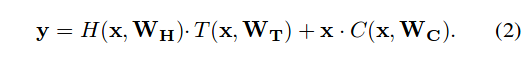

- T: transform gate, C: carry gate
- C = 1-T라 할 때

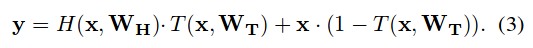

In [3]:
class Highway(nn.Module):
  def __init__(self, input_dim, num_layers, activation="relu"):
    super(Highway, self).__init__()
    self.num_lyaers = num_layers
    self.activation = activation
    self.linear_layers = nn.ModuleList([nn.Linear(input_dim, input_dim) for _ in range(num_layers)])
    self.gate_layers = nn.ModuleList([nn.Linear(input_dim, input_dim) for _ in range(num_layers)])
    self.activation = self.get_activation_function(activation)

  def forward(self, x):
    for linear, gate in zip(self.linear_layers, self.gate_layers):
      gate = F.sigmoid(gate(x))
      nonlinear = self.activation(linear(x))
      x = gate * nonlinear + (1 - gate) * x
    return x

  @staticmethod
  def get_activation_function(name):
    if name == "relu":
        return F.relu
    elif name == "tanh":
        return torch.tanh
    elif name == "sigmoid":
        return torch.sigmoid
    elif name == "leaky_relu":
        return F.leaky_relu
    else:
        raise ValueError(f"Unknown activation function: {name}")

In [4]:
class CharCNN(nn.Module):
  def __init__(self, embedding_dim, filters, n_highway, max_char_per_token, activation="relu"):
    super(CharCNN, self).__init__()
    self.char_embedding = nn.Embedding(262, embedding_dim)
    self.convolutions = nn.ModuleList([nn.Conv2d(1, num, (width, embedding_dim)) for (width, num) in filters])
    self.highway = Highway(sum(num for _ , num in filters), n_highway)
    self.max_char_per_token = max_char_per_token
    self.activation = self.highway.activation

  def forward(self, x):
    x = self.char_embedding(x).unsqueeze(1)
    convs = [F.relu(conv(x)).squeeze(3) for conv in self.convolutions]
    pools = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in convs]
    output = torch.cat(pools, 1)
    output = self.highway(output)
    return output


In [5]:
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, projection_dim=512, n_layers=2, cell_clip=3, proj_clip=3, use_skip_connections=True):
        super(BiLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.projection_dim = projection_dim
        self.n_layers = n_layers
        self.use_skip_connections = use_skip_connections
        self.cell_clip = cell_clip
        self.proj_clip = proj_clip

        self.forward_lstms = nn.ModuleList([nn.LSTM(input_size=input_dim if layer == 0 else projection_dim, hidden_size= hidden_dim, proj_size=projection_dim, batch_first=True) for layer in range(n_layers)])
        self.backward_lstms = nn.ModuleList([nn.LSTM(input_size=input_dim if layer == 0 else projection_dim, hidden_size= hidden_dim, proj_size=projection_dim, batch_first=True) for layer in range(n_layers)])

        if use_skip_connections:
            self.projections = nn.ModuleList([nn.Linear(input_dim if layer == 0 else projection_dim, projection_dim) for layer in range(n_layers)])

        self.downstream = nn.Linear(projection_dim * 2, input_dim)

    def forward(self, x):
        layer_reprs = []

        for layer in range(self.n_layers):
          x_f = x
          x_r = x_f.flip(dims=[1])

          o_f, (h_f, c_f) = self.forward_lstms[layer](x_f)
          o_r, (h_r, c_r) = self.backward_lstms[layer](x_r)
          o_r = o_r.flip(dims=[1])

          c_f = torch.clamp(c_f, -self.cell_clip, self.cell_clip)
          c_r = torch.clamp(c_r, -self.cell_clip, self.cell_clip)

          lstm_out = torch.cat((o_f, o_r), dim=-1)

          if self.use_skip_connections:
              residual = self.projections[layer](x).repeat(1,1,2)
              lstm_out = lstm_out + residual


          lstm_out = torch.clamp(lstm_out, -self.proj_clip, self.proj_clip)

          lstm_out = self.downstream(lstm_out)

          lstm_out = F.relu(lstm_out)

          lstm_out = F.dropout(lstm_out, p=0.1, training=self.training)

          layer_reprs.append(lstm_out)

          x = lstm_out

        return layer_reprs

In [6]:
class ELMo(nn.Module):
  def __init__(self, embedding_dim, filters, n_highway, max_char_per_token, hidden_dim, num_layers=2, dropout=0.1, gamma=1.0):
    super(ELMo, self).__init__()
    self.char_cnn = CharCNN(embedding_dim, filters, n_highway, max_char_per_token)
    self.bilstm = BiLSTM(sum(num for _, num in filters), hidden_dim, 512, num_layers, dropout)
    self.gamma = nn.Parameter(torch.tensor(gamma))
    self.softmax_weights = nn.Parameter(torch.ones(num_layers + 1))

  def forward(self, x):
    batch_size, seq_len, word_len = x.size()
    x = x.view(-1, word_len)
    char_embeds = self.char_cnn(x).view(batch_size, seq_len, -1)
    bilstm_out = self.bilstm(char_embeds)
    bilstm_out.insert(0, char_embeds)
    all_layers = torch.stack(bilstm_out, dim=0)
    weights = F.softmax(self.softmax_weights, dim=0)
    weighted_sum = torch.sum(weights[:, None, None, None] * all_layers, dim=0)
    elmo_representation = self.gamma * weighted_sum
    return elmo_representation


In [7]:
char_embedding_dim = 16
filters = [(1, 32), (2, 32), (3, 64), (4, 128), (5, 256)] # charcnn filters
n_highway = 2
max_char_per_token = 12
lstm_hidden_size = 4096
num_layers = 2



In [8]:
elmo_model = ELMo(char_embedding_dim, filters, n_highway, max_char_per_token, lstm_hidden_size, num_layers)



In [9]:
char_inputs = torch.randint(0, 262, (10, 20, 12))  # (batch_size, seq_len, word_len)
elmo_embeddings = elmo_model(char_inputs)
print(elmo_embeddings.shape)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:917: UserWarning: LSTM with projections is not supported with oneDNN. Using default implementation. (Triggered internally at ../aten/src/ATen/native/RNN.cpp:1473.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


torch.Size([10, 20, 512])


In [10]:
elmo_embeddings

tensor([[[0.0454, 0.2355, 0.1155,  ..., 0.1196, 0.0801, 0.1252],
         [0.0904, 0.2715, 0.1352,  ..., 0.1726, 0.0840, 0.1724],
         [0.0814, 0.2756, 0.1512,  ..., 0.0777, 0.1342, 0.2381],
         ...,
         [0.0752, 0.2519, 0.0882,  ..., 0.0669, 0.1758, 0.1650],
         [0.0624, 0.2391, 0.2055,  ..., 0.0975, 0.1262, 0.1828],
         [0.0532, 0.2528, 0.0399,  ..., 0.0717, 0.1703, 0.2163]],

        [[0.0827, 0.2465, 0.1136,  ..., 0.1342, 0.1546, 0.2121],
         [0.1005, 0.2237, 0.1600,  ..., 0.1243, 0.1034, 0.2267],
         [0.0513, 0.2679, 0.0804,  ..., 0.0850, 0.1071, 0.2051],
         ...,
         [0.0537, 0.2717, 0.1836,  ..., 0.1561, 0.1407, 0.1678],
         [0.0653, 0.2570, 0.1336,  ..., 0.1242, 0.1344, 0.1942],
         [0.0602, 0.2031, 0.0992,  ..., 0.0901, 0.1447, 0.1759]],

        [[0.0826, 0.3018, 0.1360,  ..., 0.0941, 0.1436, 0.1737],
         [0.1066, 0.2026, 0.1162,  ..., 0.0699, 0.1053, 0.2205],
         [0.1312, 0.2532, 0.2066,  ..., 0.1370, 0.1685, 0.